In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim 
from torchinfo import summary
import segmentation_models_pytorch as smp 
from torchvision import transforms

import os
# Path
from pathlib import Path

# tqdm
from tqdm.auto import tqdm 
import random
import warnings
warnings.filterwarnings("ignore")
torch.cuda.empty_cache()
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.get_device_name(), DEVICE

('NVIDIA GeForce RTX 3050 Laptop GPU', 'cuda')

In [51]:
IMAGE_PATH = Path("tusimple_preprocessed2/training/frames")
IMAGE_PATH_LIST = list(IMAGE_PATH.glob("*.*")) 
IMAGE_PATH_LIST = sorted(IMAGE_PATH_LIST) 

print(f'Total Images = {len(IMAGE_PATH_LIST)}')


Total Images = 23258


In [52]:
MASK_PATH = Path("tusimple_preprocessed2/training/lane-masks")
MASK_PATH_LIST = list(MASK_PATH.glob("*.*"))
MASK_PATH_LIST = sorted(MASK_PATH_LIST)

print(f'Total Masks = {len(MASK_PATH_LIST)}')


Total Masks = 23258


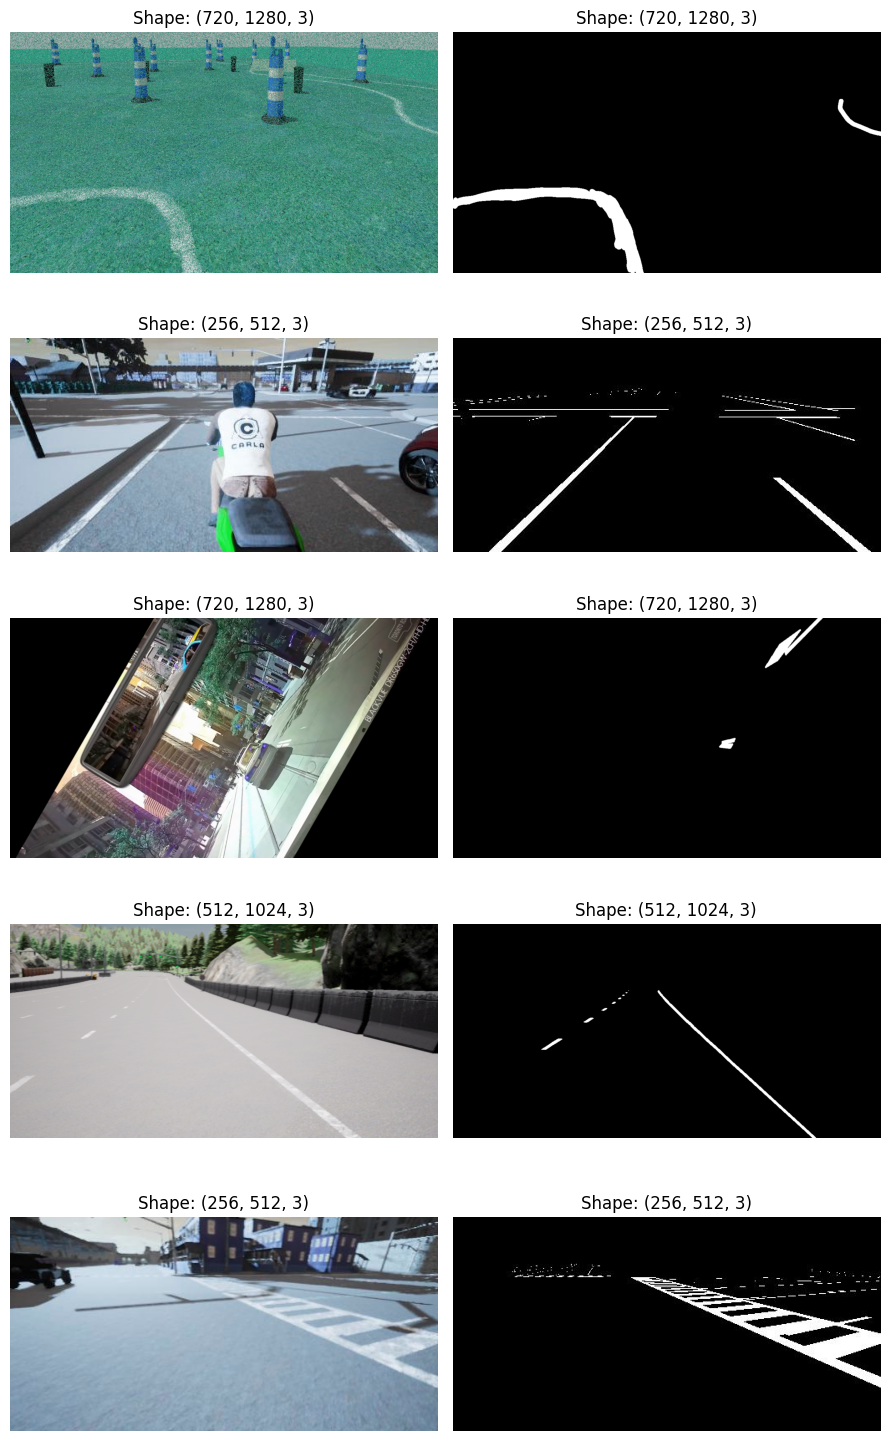

In [53]:
fig,ax = plt.subplots(nrows = 5, ncols = 2, figsize = (9,15))
image_indices = list(range(len(IMAGE_PATH_LIST)))
random.shuffle(image_indices)

shuffled_paths = zip([IMAGE_PATH_LIST[i] for i in image_indices], [MASK_PATH_LIST[i] for i in image_indices])

for i,(img_path, mk_path) in enumerate(shuffled_paths): 
    if i>4: 
        break
    img_bgr = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) 
    
    ax[i,0].imshow(img_bgr) 
    ax[i,0].axis('off')
    ax[i,0].set_title(f'Shape: {img_rgb.shape}')
    
    mask_bgr = cv2.imread(str(mk_path))
    mask_rgb = cv2.cvtColor(mask_bgr, cv2.COLOR_BGR2RGB)
    ax[i,1].imshow(mask_rgb) 
    ax[i,1].axis('off')
    ax[i,1].set_title(f'Shape: {mask_rgb.shape}')

fig.tight_layout()
fig.show()


In [55]:
images_paths = [None] * len(IMAGE_PATH_LIST)
masks_paths = [None] * len(MASK_PATH_LIST)
for i,(img_path, mask_path) in enumerate(zip(IMAGE_PATH_LIST, MASK_PATH_LIST)): 
    images_paths[i] = img_path
    masks_paths[i] = mask_path
    

data = pd.DataFrame({'Image':images_paths, 'Mask':masks_paths}) 
data= data.sample(n=10000)
data.reset_index(drop=True, inplace=True)

print(len(data))
data.head()


10000


,Image,Mask
0,tusimple_preprocessed2/training/frames/Town04_...,tusimple_preprocessed2/training/lane-masks/Tow...
1,tusimple_preprocessed2/training/frames/Lane_In...,tusimple_preprocessed2/training/lane-masks/Lan...
2,tusimple_preprocessed2/training/frames/Augment...,tusimple_preprocessed2/training/lane-masks/Aug...
3,tusimple_preprocessed2/training/frames/Town04_...,tusimple_preprocessed2/training/lane-masks/Tow...
4,tusimple_preprocessed2/training/frames/Augment...,tusimple_preprocessed2/training/lane-masks/Aug...


In [56]:
SEED = 42

data_train, data_rest = train_test_split(data, 
                                         test_size = 0.3, 
                                         random_state = SEED)

data_val, data_test = train_test_split(data_rest, 
                                       test_size = 0.5, 
                                       random_state = SEED)


In [57]:
color2id = {(0, 0, 0): 0, # #b83df5: backgroud
            (255, 255, 255):1, # #ff355e: road_sign
           } 


In [58]:
def mapping_color(img:Image, color2id:dict):
    
    image = np.array(img) 
    
    height,width,_ = image.shape 
    output_matrix = np.full(shape = (height, width), fill_value = -1, dtype = np.int32) 
    
    for h in range(height):
        for w in range(width): 
            color_pixel = tuple(image[h,w,:]) 
            
            if color_pixel in color2id: 
                output_matrix[h,w] = color2id[color_pixel]
            
    return output_matrix

In [59]:
class CustomDataset(Dataset):
    def __init__(self, data:pd.DataFrame, color2id:dict, image_transforms, mask_transforms):
        self.data = data
        self.color2id = color2id
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        
        image_path = data.iloc[idx, 0]
        image = Image.open(image_path).convert("RGB")
        image = self.image_transforms(image)
        
        mask_path = data.iloc[idx, 1]
        mask = Image.open(mask_path).convert("RGB")
        mask = self.mask_transforms(mask)
        mask = mapping_color(mask, self.color2id)
    
        return image, mask


In [60]:
RESIZE = (256, 256)

image_transforms = transforms.Compose([transforms.Resize(RESIZE), 
                                       transforms.ToTensor()])

mask_transforms = transforms.Compose([transforms.Resize(RESIZE)])

In [61]:
train_dataset = CustomDataset(data_train, 
                              color2id, 
                              image_transforms, 
                              mask_transforms)

val_dataset = CustomDataset(data_val, 
                            color2id, 
                            image_transforms, 
                            mask_transforms)


In [62]:
BATCH_SIZE = 32
NUM_WORKERS = 8

train_dataloader = DataLoader(dataset = train_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = True, 
                              num_workers = NUM_WORKERS,
                              pin_memory=True)

val_dataloader = DataLoader(dataset = val_dataset, 
                            batch_size = 1, 
                            shuffle = True, 
                            num_workers = NUM_WORKERS,
                            pin_memory=True)


In [63]:
batch_images, batch_masks = next(iter(train_dataloader))

batch_images.shape, batch_masks.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32, 256, 256]))

In [64]:
model = smp.Unet(classes = 2)
#model = smp.FPN(classes=2)
#model = smp.Linknet(classes=2)
model = model.to(DEVICE)

In [65]:
summary(model = model,
        col_width = 17, 
        input_size = [1,3,256,256], 
        col_names = ['input_size','output_size','num_params','trainable'],
        row_settings = ['var_names']) 



Layer (type (var_name))                            Input Shape       Output Shape      Param #           Trainable
Unet (Unet)                                        [1, 3, 256, 256]  [1, 2, 256, 256]  --                True
├─ResNetEncoder (encoder)                          [1, 3, 256, 256]  [1, 3, 256, 256]  --                True
│    └─Conv2d (conv1)                              [1, 3, 256, 256]  [1, 64, 128, 128] 9,408             True
│    └─BatchNorm2d (bn1)                           [1, 64, 128, 128] [1, 64, 128, 128] 128               True
│    └─ReLU (relu)                                 [1, 64, 128, 128] [1, 64, 128, 128] --                --
│    └─MaxPool2d (maxpool)                         [1, 64, 128, 128] [1, 64, 64, 64]   --                --
│    └─Sequential (layer1)                         [1, 64, 64, 64]   [1, 64, 64, 64]   --                True
│    │    └─BasicBlock (0)                         [1, 64, 64, 64]   [1, 64, 64, 64]   73,984            True
│    │   

In [66]:
for param in model.encoder.parameters():
    param.requires_grad = False  


In [67]:
summary(model = model, 
        col_width = 17, 
        input_size = [1,3,256,256],
        col_names = ['input_size','output_size','num_params','trainable'], 
        row_settings = ['var_names'])

Layer (type (var_name))                            Input Shape       Output Shape      Param #           Trainable
Unet (Unet)                                        [1, 3, 256, 256]  [1, 2, 256, 256]  --                Partial
├─ResNetEncoder (encoder)                          [1, 3, 256, 256]  [1, 3, 256, 256]  --                False
│    └─Conv2d (conv1)                              [1, 3, 256, 256]  [1, 64, 128, 128] (9,408)           False
│    └─BatchNorm2d (bn1)                           [1, 64, 128, 128] [1, 64, 128, 128] (128)             False
│    └─ReLU (relu)                                 [1, 64, 128, 128] [1, 64, 128, 128] --                --
│    └─MaxPool2d (maxpool)                         [1, 64, 128, 128] [1, 64, 64, 64]   --                --
│    └─Sequential (layer1)                         [1, 64, 64, 64]   [1, 64, 64, 64]   --                False
│    │    └─BasicBlock (0)                         [1, 64, 64, 64]   [1, 64, 64, 64]   (73,984)          False
│

In [68]:
loss_fn = smp.losses.DiceLoss(mode = "multiclass", classes = 2, ignore_index = -1) 

optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay = 0.0001) 

In [69]:
class EarlyStopping:
    def __init__(self, patience:int = 3, delta:float = 0.00001, path = "best_model.pth"):
        self.patience = patience 
        self.delta = delta
        self.path = path
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        
    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(model)
            
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

            print(self.counter)
                
        else:
            self.best_score = val_loss
            self.save_checkpoint(model)
            self.counter = 0
            
    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)


In [70]:
# EarlyStopping
early_stopping = EarlyStopping(patience=5, delta=0.)

In [71]:
def train_step(model:torch.nn.Module, dataloader:torch.utils.data.DataLoader, 
               loss_fn:smp.losses, optimizer:torch.optim.Optimizer):
    
    model.train() 
    
    train_loss = 0.
    train_iou = 0.
    
    for batch,(X,y) in enumerate(dataloader):
        X = X.to(device = DEVICE, dtype = torch.float32) 
        y = y.to(device = DEVICE, dtype = torch.long)    
        
        optimizer.zero_grad() 
        
        pred_logit = model(X) 
        loss = loss_fn(pred_logit, y) 
        train_loss = loss.item()
        
        loss.backward() 
        optimizer.step()
        
        pred_prob = pred_logit.softmax(dim = 1)
        pred_class = pred_prob.argmax(dim = 1) 
        
        tp,fp,fn,tn = smp.metrics.get_stats(output = pred_class.detach().to(DEVICE).long(), 
                                            target = y.to(DEVICE), 
                                            mode = "multiclass", 
                                            ignore_index = -1, 
                                            num_classes = 2)
        
        train_iou += smp.metrics.iou_score(tp, fp, fn, tn, reduction = "micro")
        
    train_loss = train_loss / len(dataloader)
    train_iou = train_iou / len(dataloader)
    
    return train_loss, train_iou

In [72]:
def val_step(model:torch.nn.Module, dataloader:torch.utils.data.DataLoader, 
             loss_fn:smp.losses):
    
    model.eval()
    
    val_loss = 0.
    val_iou = 0.
    
    with torch.inference_mode():
    
        for batch,(X,y) in enumerate(dataloader):
            X = X.to(device = DEVICE, dtype = torch.float32)
            y = y.to(device = DEVICE, dtype = torch.long)

            pred_logit = model(X)
            loss = loss_fn(pred_logit, y)
            val_loss = loss.item()

            pred_prob = pred_logit.softmax(dim = 1)
            pred_class = pred_prob.argmax(dim = 1)

            tp,fp,fn,tn = smp.metrics.get_stats(output = pred_class.detach().to(DEVICE).long(), 
                                                target = y.to(DEVICE), 
                                                mode = "multiclass", 
                                                ignore_index = -1, 
                                                num_classes = 2)

            val_iou += smp.metrics.iou_score(tp, fp, fn, tn, reduction = "micro")
        
        
    val_loss = val_loss / len(dataloader)
    val_iou = val_iou / len(dataloader)
    
    return val_loss, val_iou


In [73]:
def train(model:torch.nn.Module, train_dataloader:torch.utils.data.DataLoader, 
          val_dataloader:torch.utils.data.DataLoader, loss_fn:torch.nn.Module, optimizer:torch.optim.Optimizer, 
          early_stopping, epochs:int = 10):
    
    results = {'train_loss':[], 'train_iou':[], 'val_loss':[], 'val_iou':[]}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_iou = train_step(model = model, 
                                           dataloader = train_dataloader, 
                                           loss_fn = loss_fn, 
                                           optimizer = optimizer)
        
        val_loss, val_iou = val_step(model = model, 
                                     dataloader = val_dataloader, 
                                     loss_fn = loss_fn)
        
        print(f'Epoch: {epoch + 1} | ', 
              f'Train Loss: {train_loss:.4f} | ', 
              f'Train IOU: {train_iou:.4f} | ', 
              f'Val Loss: {val_loss:.4f} | ', 
              f'Val IOU: {val_iou:.4f}')
        
        
        early_stopping(val_loss, model)
        
        if early_stopping.early_stop == True:
            print("Early Stopping!!")
            break
            
        results['train_loss'].append(train_loss)
        results['train_iou'].append(train_iou)
        results['val_loss'].append(val_loss)
        results['val_iou'].append(val_iou)
        
    return results

In [74]:
# Training!!!
EPOCHS = 200

torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

RESULTS = train(model.to(device = DEVICE), 
                train_dataloader, 
                val_dataloader, 
                loss_fn, 
                optimizer, 
                early_stopping, 
                EPOCHS)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1 |  Train Loss: 0.0007 |  Train IOU: 0.9626 |  Val Loss: 0.0002 |  Val IOU: 0.9892
Epoch: 2 |  Train Loss: 0.0006 |  Train IOU: 0.9900 |  Val Loss: 0.0003 |  Val IOU: 0.9916
1
Epoch: 3 |  Train Loss: 0.0006 |  Train IOU: 0.9913 |  Val Loss: 0.0003 |  Val IOU: 0.9919
2
Epoch: 4 |  Train Loss: 0.0004 |  Train IOU: 0.9917 |  Val Loss: 0.0001 |  Val IOU: 0.9921
Epoch: 5 |  Train Loss: 0.0007 |  Train IOU: 0.9920 |  Val Loss: 0.0003 |  Val IOU: 0.9929
1
Epoch: 6 |  Train Loss: 0.0003 |  Train IOU: 0.9925 |  Val Loss: 0.0000 |  Val IOU: 0.9930
Epoch: 7 |  Train Loss: 0.0005 |  Train IOU: 0.9928 |  Val Loss: 0.0000 |  Val IOU: 0.9933
1
Epoch: 8 |  Train Loss: 0.0006 |  Train IOU: 0.9927 |  Val Loss: 0.0003 |  Val IOU: 0.9935
2
Epoch: 9 |  Train Loss: 0.0005 |  Train IOU: 0.9931 |  Val Loss: 0.0003 |  Val IOU: 0.9939
3
Epoch: 10 |  Train Loss: 0.0004 |  Train IOU: 0.9932 |  Val Loss: 0.0000 |  Val IOU: 0.9935
4
Epoch: 11 |  Train Loss: 0.0004 |  Train IOU: 0.9934 |  Val Loss: 0.0001 | 

In [25]:
def loss_and_metric_plot(results:dict):
    training_loss = results['train_loss']
    valid_loss = results['val_loss']
    
    training_iou = results['train_iou']
    valid_iou = results['val_iou']
    
    fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (9,4))
    axes = axes.flat
    
    axes[0].plot(range(len(training_loss)), training_loss)
    axes[0].plot(range(len(valid_loss)), valid_loss)
    axes[0].set_xlabel("Epoch", fontsize = 12, fontweight = "bold", color = "black")
    axes[0].set_ylabel("Loss", fontsize = 12, fontweight = "bold", color = "black")
    axes[0].set_title("Dice Loss", fontsize = 14, fontweight = "bold", color = "blue")
    
    axes[1].plot(range(len(training_iou)), training_iou)
    axes[1].plot(range(len(valid_iou)), valid_iou)
    axes[1].set_xlabel("Epoch", fontsize = 12, fontweight = "bold", color = "black")
    axes[1].set_ylabel("score", fontsize = 12, fontweight = "bold", color = "black")
    axes[1].set_title("IOU", fontsize = 14, fontweight = "bold", color = "red")
    
    fig.tight_layout()
    fig.show()

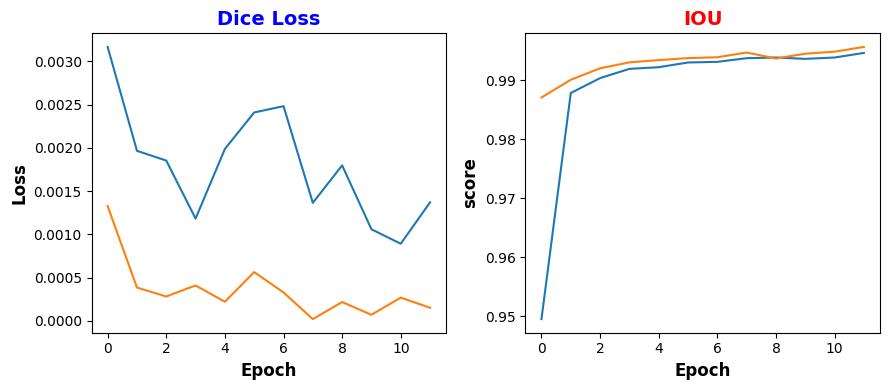

In [26]:
loss_and_metric_plot(RESULTS)

In [27]:
def predictions(test_dataloader:torch.utils.data.DataLoader, best_model:str):
    
    checkpoint = torch.load(best_model)
    
    loaded_model = smp.Unet(encoder_name = "resnet34", encoder_weights = None, classes = 2)

    loaded_model.load_state_dict(checkpoint)

    loaded_model.to(device = DEVICE)

    loaded_model.eval()

    pred_mask_test = []

    with torch.inference_mode():
        for X,_ in tqdm(test_dataloader):
            X = X.to(device = DEVICE, dtype = torch.float32)
            logit_mask = loaded_model(X)
            prob_mask = logit_mask.softmax(dim = 1)
            pred_mask = prob_mask.argmax(dim = 1)
            pred_mask_test.append(pred_mask.detach().cpu())

    pred_mask_test = torch.cat(pred_mask_test)

    return pred_mask_test


In [28]:
test_dataset = CustomDataset(data_test, color2id, image_transforms, mask_transforms)

test_dataloader = DataLoader(dataset = test_dataset, 
                             batch_size = BATCH_SIZE, 
                             shuffle = False)


In [29]:
pred_mask_test = predictions(test_dataloader, "best_model.pth")

  0%|          | 0/10 [00:00<?, ?it/s]

In [30]:
IMAGE_TEST = []
MASK_TEST = []

for img,mask in test_dataloader:
    IMAGE_TEST.append(img)
    MASK_TEST.append(mask)

IMAGE_TEST = torch.cat(IMAGE_TEST)

MASK_TEST = torch.cat(MASK_TEST)


In [31]:
TP, FP, FN, TN = smp.metrics.get_stats(output = pred_mask_test.long(), 
                                       target = MASK_TEST.long(), 
                                       mode = "multiclass", 
                                       ignore_index = -1, 
                                       num_classes = 2)

In [32]:
iou_test = smp.metrics.iou_score(TP, FP, FN, TN, reduction = "micro")
print(f'IOU Test = {iou_test:.4f}')

IOU Test = 0.9946


In [33]:
id2color = {0: (0, 0, 0), # background
            1: (255, 255, 255), # road_sign
           } 


In [34]:
total_mask_output = []

for i,mask_pred in enumerate(pred_mask_test):
    
    height,width = mask_pred.shape
    
    mask_original = MASK_TEST[i]
    ignore = mask_original == -1 # id: -1
    
    mask_predicted = torch.where(ignore, -1, mask_pred)
    mask_zeros = torch.zeros(size = (height, width, 3), dtype = torch.uint8)
    
    for h in range(height):
        for w in range(width):
            idcolor = int(mask_predicted[h,w])
            
            if idcolor in id2color:
                mask_zeros[h,w,:] = torch.tensor(id2color[idcolor])
    
    total_mask_output.append(mask_zeros)


In [35]:
total_mask_test = []

for mask_tst in MASK_TEST:
    
    height,width = mask_tst.shape
    
    mask_zeros = torch.zeros(size = (height, width, 3), dtype = torch.uint8)
    
    for h in range(height):
        for w in range(width):
            idcolor = int(mask_tst[h,w])
            
            if idcolor in id2color:
                mask_zeros[h,w,:] = torch.tensor(id2color[idcolor])
    
    total_mask_test.append(mask_zeros)

300


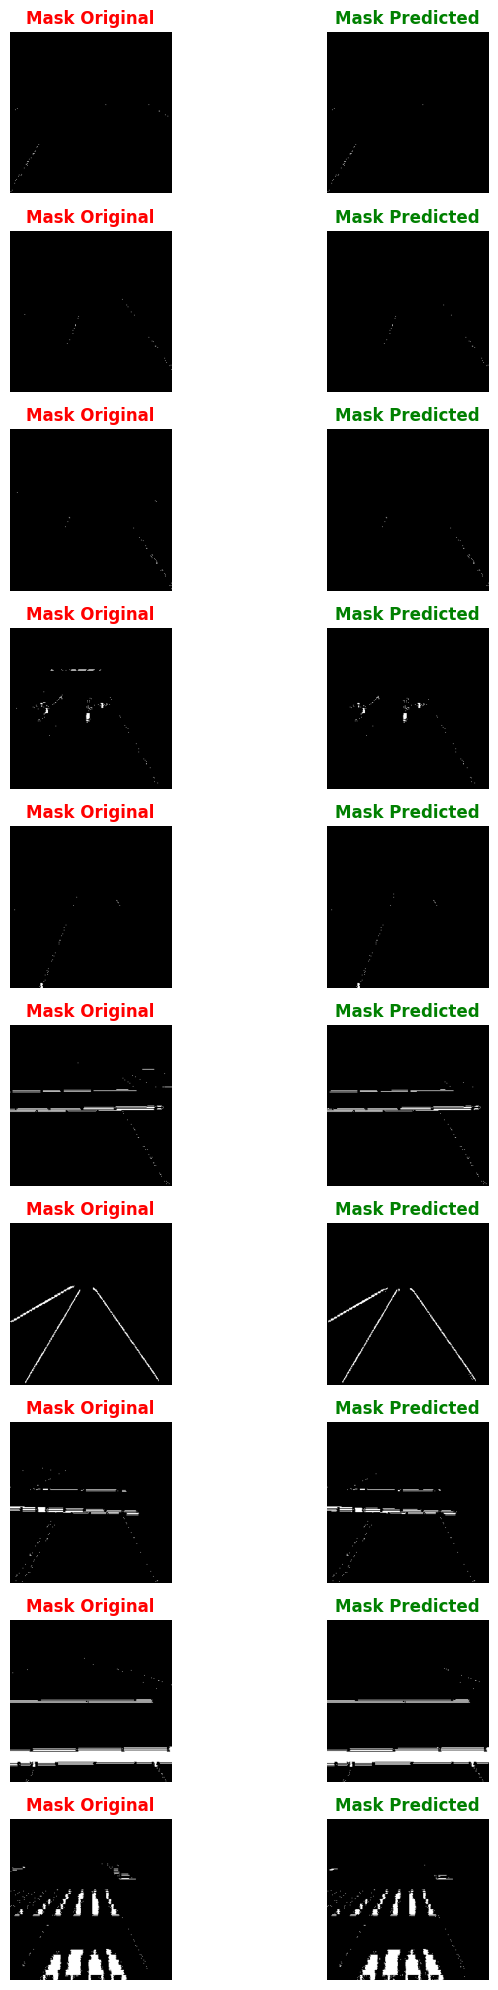

In [36]:
fig, ax = plt.subplots(nrows = 10, ncols = 2, figsize = (8,20))
print(len(total_mask_test))
for i,(mk_out,mk_test) in enumerate(zip(total_mask_output, total_mask_test)):
    if i >=10:
        break
    mask_test = mk_test.numpy()
    ax[i,0].imshow(mask_test)
    ax[i,0].set_title("Mask Original", fontsize = 12, fontweight = "bold", color = "red")
    ax[i,0].axis('off')
    
    mask_out = mk_out.numpy()
    ax[i,1].imshow(mask_out)
    ax[i,1].set_title("Mask Predicted", fontsize = 12, fontweight = "bold", color = "green")
    ax[i,1].axis('off')
    
fig.tight_layout()
fig.show()